<a href="https://colab.research.google.com/github/yjh111172/medical-data-analysis/blob/main/09__solubility_prediction_model_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepChem 설치

Colab 노트북에 DeepChem 설치

tensorflow 기반 모델을 사용할 것이므로 pip install 명령에 [tensorflow]를 추가하여 필요한 종속성도 설치

In [ ]:
# DeepChem 설치시 Keras 종속성 버전 일치를 위해 아래 환경 변수 설정 후 import 진행
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

In [ ]:
!pip install deepchem[tensorflow]

## 기타 모듈 설치
- rdkit 설치
- 레거시 옵티마이저 사용을 위한 tf_keras 설치(deepchem ver 2.4.0일 때만)

In [ ]:
!pip install rdkit

In [ ]:
!pip install tf_keras

## deepchem 버전 확인

In [ ]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.0'

## warning 메시지 생략

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# 분자 데이터 피처화

In [ ]:
from rdkit import Chem

# SMILES와 확장 연결 지문(ECFP)
smiles_example = ['C1CCCCC1C', 'O1CCOCC1']
mols = [Chem.MolFromSmiles(s) for s in smiles_example] # rdkit 라이브러리를 사용하여 SMILES 문자열을 분자 객체로 변환
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
arr.shape

[19:45:25] DEPRECATION WARNING: please use MorganGenerator
[19:45:25] DEPRECATION WARNING: please use MorganGenerator


(2, 1024)

In [ ]:
# 분자 표현자
feat = dc.feat.RDKitDescriptors()
arr = feat.featurize(mols)
arr.shape

(2, 217)

# 용해도 예측 모델 만들기
DeepChem 라이브러리를 사용하여 그래프 합성곱 신경망을 학습시켜 분자의 용해도를 예측하는 실습 진행

Delaney 데이터 : 분자의 SMILES 표현과 해당 분자의 용해도 값을 포함함

## 데이터 불러오기 및 확인

In [ ]:
import deepchem as dc
#

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

## 모델 생성 및 훈련

In [ ]:
# 모델 생성 및 훈련
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, batch_normalize=False) # n_tasks : 출력층 지정
model.fit(train_dataset, nb_epoch=100)

0.06512631416320801

## 모델 평가

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score) # 피어슨 상관계수 평가지표 사용
print("Training set score")
print(model.evaluate(train_dataset, [metric], transformers))
print("Test set score")
print(model.evaluate(test_dataset, [metric], transformers))

Training set score
{'pearson_r2_score': np.float64(0.945392959012276)}
Test set score
{'pearson_r2_score': np.float64(0.6922979533443355)}


In [ ]:
# 용해도 예측
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']

mols = [Chem.MolFromSmiles(s) for s in smiles] # SMILES 문자열 -> 분자 객체로 변환
featurizer = dc.feat.ConvMolFeaturizer() # 분자를 Graph 구조로 변환하는 featurizer 정의
x = featurizer.featurize(mols) # Node와 Edge로 이루어진 Graph 구조로 변환
predicted_solubility = model.predict_on_batch(x)

[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:46:17] DEPRECATION WARNING: please use GetValen

In [ ]:
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.59185123]

Molecule: CCOC(=O)CC
Predicted solubility: [1.4190775]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [-0.00503433]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [0.01909553]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.29576275]


# SMART 문자열
- 분자 내 원자들의 특정 패턴 찾기

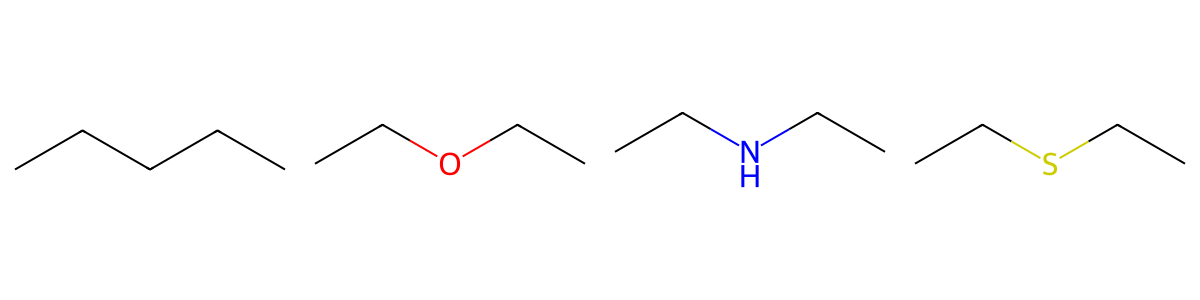

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
smiles_for_smart = ["CCCCC", "CCOCC", "CCNCC", "CCSCC"]
mols_for_smart = [Chem.MolFromSmiles(s) for s in smiles_for_smart]
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300))

In [ ]:
query = Chem.MolFromSmarts("CCC")
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (), (), ()]

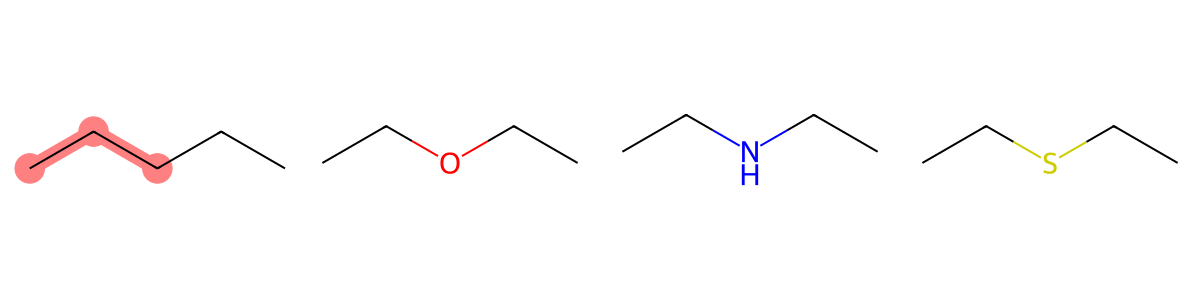

In [ ]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)

In [ ]:
query = Chem.MolFromSmarts("C[C,N,O]C") # 2개의 탄소 원자 사이에 탄소 or 산소 or 질소 원자 하나가 결합해 있음
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (1, 2, 3), (1, 2, 3), ()]

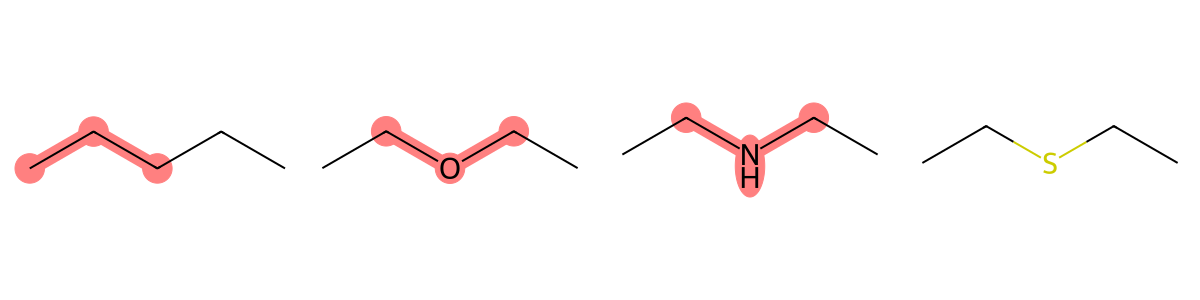

In [ ]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)

### 확인 문제
- wildcard (*)를 사용해서 "?"에 들어갈 문자열을 작성하세요

In [ ]:
wildcard_text = "?"
query = Chem.MolFromSmarts(wildcard_text)
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (1, 2, 3), (1, 2, 3), (1, 2, 3)]

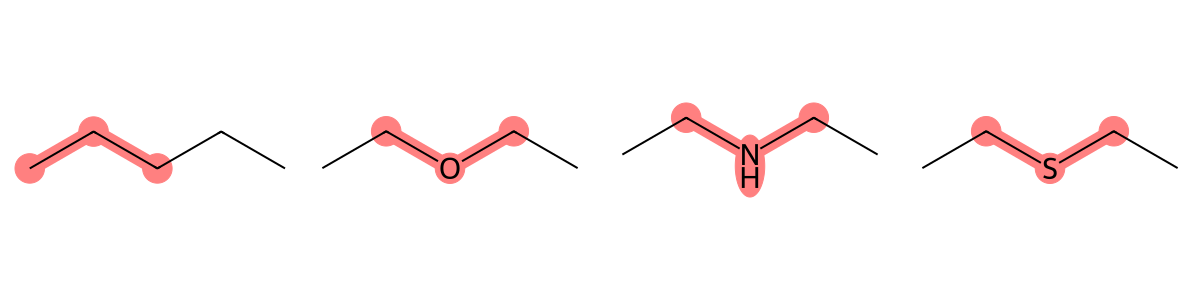

In [ ]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)